In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import Tuple, List

# Defining file path
ecg_folder = "../../../../Datasets/12-lead electrocardiogram database/ECGData"
attributes_file = "../../../../Datasets/12-lead electrocardiogram database/AttributesDictionary.xlsx"
diagnostics_file = "../../../../Datasets/12-lead electrocardiogram database/Diagnostics.xlsx"
rhythm_names_file = "../../../../Datasets/12-lead electrocardiogram database/RhythmNames.xlsx"

# Checking for missing files and stuff
for file_path in [attributes_file, diagnostics_file, rhythm_names_file]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Required file not found: {file_path}")

# Loading metadata
attributes_df = pd.read_excel(attributes_file)
diagnostics_df = pd.read_excel(diagnostics_file)
rhythm_names_df = pd.read_excel(rhythm_names_file)

# Removing trailing spaces in acronym columns for accurate matching
rhythm_names_df['Acronym Name'] = rhythm_names_df['Acronym Name'].str.strip()

# Creating sets of valid acronyms for rhythm
valid_rhythms = set(rhythm_names_df['Acronym Name'])
print(valid_rhythms)

{'SB', 'AF', 'AFIB', 'SAAWR', 'AVRT', 'SR', 'SI', 'AT', 'SVT', 'ST', 'AVNRT'}


In [2]:
# Based from here <https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection>
class PanTompkinsQRS:
    def __init__(self, sampling_rate: int = 500):
        self.fs = sampling_rate

    def bandpass_filter(self, data: np.ndarray) -> np.ndarray:
        """
        Apply bandpass filter (5-15 Hz) to remove noise
        """
        lowcut = 5.0
        highcut = 15.0
        nyquist = self.fs * 0.5
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(2, [low, high], btype='band')
        return signal.filtfilt(b, a, data)

    @staticmethod
    def derivative(data: np.ndarray) -> np.ndarray:
        """
        Apply derivative filter to emphasize QRS slopes
        """
        return np.gradient(data)

    @staticmethod
    def squaring(data: np.ndarray) -> np.ndarray:
        """
        Square the signal to make all points positive and emphasize high frequencies
        """
        return np.power(data, 2)

    @staticmethod
    def moving_window_integration(data: np.ndarray, window_size: int = 30) -> np.ndarray:
        """
        Apply moving window integration
        """
        window = np.ones(window_size) / window_size
        return np.convolve(data, window, mode='same')

    def detect_qrs(self, data: np.ndarray) -> Tuple[List[int], np.ndarray]:
        """
        Detect QRS complexes in the ECG signal
        Returns: peaks locations and processed signal
        """
        # Apply bandpass filter
        filtered = self.bandpass_filter(data)

        # Apply derivative
        derivative = self.derivative(filtered)

        # Square the signal
        squared = self.squaring(derivative)

        # Moving window integration
        integrated = self.moving_window_integration(squared)

        # Find peaks
        distance = int(0.2 * self.fs)  # Minimum distance between peaks (200ms)
        peaks, _ = signal.find_peaks(integrated, distance=distance)

        return peaks, integrated


def load_and_process_ecg(file_path: str, lead_number: int = 0) -> np.ndarray:
    """
    Load ECG data from the Chapman dataset and process specified lead
    """
    try:
        # Load the data
        data = pd.read_csv(file_path, skiprows=1, header=None).values
        # Extract specified lead
        lead_data = data[:, lead_number]
        return lead_data
    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        return None


def analyze_ecg_file(file_path: str, lead_number: int = 0) -> dict:
    """
    Analyze a single ECG file and return metrics
    """
    # Load and process the ECG data
    ecg_data = load_and_process_ecg(file_path, lead_number)
    if ecg_data is None:
        print(file_path + " is empty")
        return None

    # Initialize Pan-Tompkins QRS detector
    qrs_detector = PanTompkinsQRS()

    # Detect QRS complexes
    peaks, processed_signal = qrs_detector.detect_qrs(ecg_data)

    # Calculate basic heart rate metrics
    if len(peaks) > 1:
        # Calculate RR intervals in seconds
        rr_intervals = np.diff(peaks) / qrs_detector.fs

        # Calculate heart rate in BPM
        heart_rate = 60 / np.mean(rr_intervals)

        # Calculate heart rate variability (standard deviation of RR intervals)
        hrv = np.std(rr_intervals) * 1000  # in milliseconds

        return {
            'num_beats': len(peaks),
            'heart_rate': heart_rate,
            'hrv': hrv,
            'peaks': peaks,
            'processed_signal': processed_signal,
            'raw_signal': ecg_data
        }

    print("Could not find peaks for ", file_path)

    return None


# Example usage with your dataset structure
def process_chapman_dataset(ecg_folder: str, diagnostics_df: pd.DataFrame):
    """
    Process all ECG files in the Chapman dataset
    """
    results = []

    for filename in os.listdir(ecg_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(ecg_folder, filename)

            # Get the record ID from filename
            record_id = filename.split('.')[0]

            analysis = analyze_ecg_file(file_path, lead_number=1)

            if analysis:
                # Get diagnostic information
                diagnostic_info = diagnostics_df[diagnostics_df['FileName'] == record_id]

                result = {
                    'record_id': record_id,
                    'heart_rate': analysis['heart_rate'],
                    'hrv': analysis['hrv'],
                    'num_beats': analysis['num_beats']
                }

                # Add diagnostic information if available
                if not diagnostic_info.empty:
                    result['rhythm'] = diagnostic_info['Rhythm'].iloc[0]

                results.append(result)

    return pd.DataFrame(results)


def plot_ecg_analysis(ecg_data: dict, title: str = "ECG Analysis"):
    """
    Visualize ECG data with detected QRS complexes
    """
    plt.figure(figsize=(15, 10))

    # Plot raw signal
    plt.subplot(2, 1, 1)
    plt.plot(ecg_data['raw_signal'])
    plt.scatter(ecg_data['peaks'], ecg_data['raw_signal'][ecg_data['peaks']],
                color='red', label='QRS Complexes')
    plt.title(f"{title} - Raw Signal")
    plt.legend()

    # Plot processed signal
    plt.subplot(2, 1, 2)
    plt.plot(ecg_data['processed_signal'])
    plt.scatter(ecg_data['peaks'], ecg_data['processed_signal'][ecg_data['peaks']],
                color='red', label='QRS Complexes')
    plt.title("Processed Signal")
    plt.legend()

    plt.tight_layout()
    plt.show()

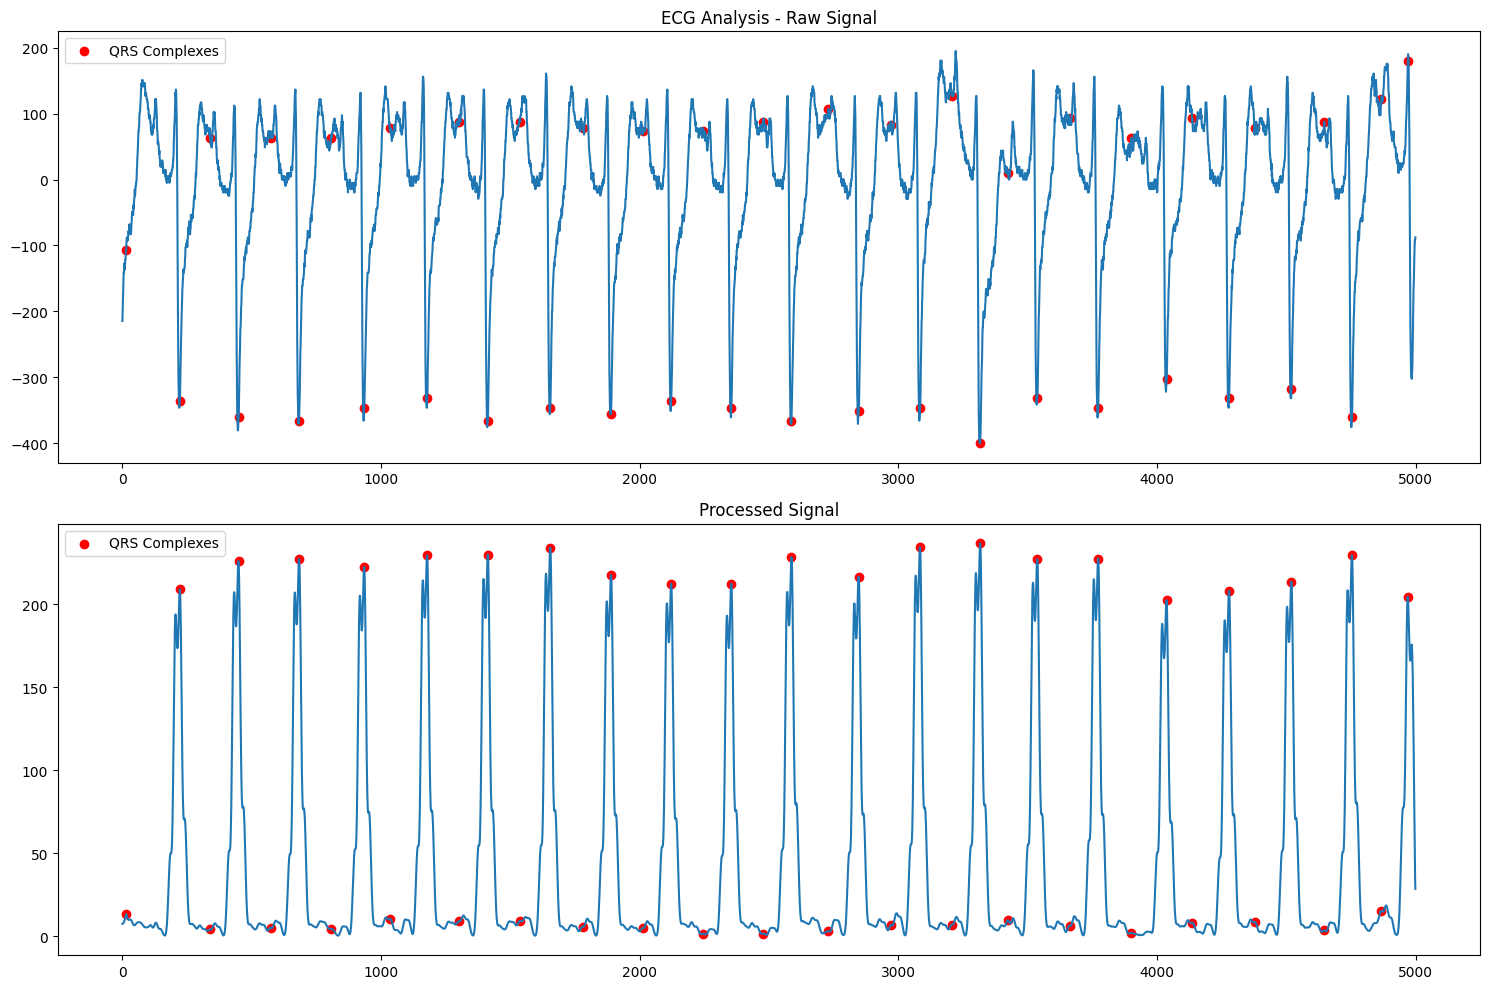

                    record_id  heart_rate        hrv  num_beats rhythm
0  MUSE_20180712_153346_94000  250.254323  72.618207         42     AF
1  MUSE_20180712_155025_88000  220.588235  63.655322         37     AF
2  MUSE_20180118_133731_39000  191.161357  71.978376         32     SB
3  MUSE_20180113_123833_74000  226.623111  45.603109         38     SB
4  MUSE_20180210_122045_58000  218.270008  45.637325         37     SR


In [3]:
processor = PanTompkinsQRS()

# Process a single file
file_path = os.path.join(ecg_folder, "MUSE_20180111_155115_19000.csv")
analysis = analyze_ecg_file(file_path)

# Visualize results
if analysis:
    plot_ecg_analysis(analysis, title="ECG Analysis")

# Process entire dataset
results_df = process_chapman_dataset(ecg_folder, diagnostics_df)
print(results_df.head())

In [4]:
results_df

,record_id,heart_rate,hrv,num_beats,rhythm
0,MUSE_20180712_153346_94000,250.254323,72.618207,42,AF
1,MUSE_20180712_155025_88000,220.588235,63.655322,37,AF
2,MUSE_20180118_133731_39000,191.161357,71.978376,32,SB
3,MUSE_20180113_123833_74000,226.623111,45.603109,38,SB
4,MUSE_20180210_122045_58000,218.270008,45.637325,37,SR
...,...,...,...,...,...
10641,MUSE_20180112_133230_46000,224.378411,66.811336,38,AFIB
10642,MUSE_20180115_123926_81000,196.439533,50.683415,33,AT
10643,MUSE_20180210_121128_24000,233.463035,28.678802,39,SR
10644,MUSE_20180210_123928_58000,203.285421,79.052005,34,SR


In [5]:
results_df.describe()

,heart_rate,hrv,num_beats
count,10646.000000,10646.000000,10646.000000
mean,212.593840,54.222943,35.697539
std,17.336301,17.658692,2.848319
min,134.969325,0.853750,23.000000
25%,204.630012,45.754053,34.000000
50%,213.501423,56.575764,36.000000
75%,221.902609,65.418577,37.000000
max,292.623451,118.225698,49.000000
